In [746]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import csv
import random
import pandas as pd
import scipy.stats as st
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import math



Kalman filter is a gaussian filtering process that removes noise and allows identification of state of the system. Commonly used in control theory. https://nbviewer.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

Here, its being used to identify the steady state equilibrium diffusion regime. The mass v time data from each permeability run can be used to generate filtered mass v time and mass loss v time (the derivative). Equilibrium regime is where the filtered loss v time is steady and mass is decreasing.

Import and convert the data to mass v time data

In [747]:
def convert_to_mass(file_name):
    cell_ = pd.read_csv("./" + file_name + ".csv", header=0)
    controls = pd.read_csv("/Users/kfransen/Documents/permeability_analysis/" +"Calibration_7_15_1to16"+ ".csv", header=0)
    #get slopes from the calibration curve
    #first row is the number of the scale, second row is the mass in grams and scale response
    slopes=[0]*16
    intercepts=[0]*16
    for i in range(1,17,1):
        response=controls.iloc[1:len(controls.index),2 * (i - 1) + 1:2 * (i - 1) + 2].to_numpy()
        mass=controls.iloc[1:len(controls.index),2 * (i - 1) :2 * (i - 1) + 1].to_numpy()
        mass=np.reshape(mass,-1)
        #print(mass)
        mass=mass.astype(float)
        response=np.reshape(response.astype(float),-1)
        #print(response, mass)
        output=st.linregress(response, mass)
        #print(output)
        slopes[i-1]=output.slope
        intercepts[i-1]=output.intercept

    print(slopes)
    #convert to mass
    mass_data=cell_
    #print(mass_data)
    for i in range(0,16,1):
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2])
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]*slopes[i-1])
        mass_data=mass_data.dropna(axis=0)
        mass_data=mass_data.astype('float64')
        #print(mass_data.dtypes)
        #print(mass_data.iloc[:,2*(i)+1:2*(i)+2])
        mass_data.iloc[:,2*(i)+1:2*(i)+2]=mass_data.iloc[:,2*(i)+1:2*(i)+2]*slopes[i]+intercepts[i]
    normalization=mass_data.iloc[0,:].to_numpy()
    #print(normalization)
    #get an updated matrix
    update1=mass_data.apply(lambda x: x-normalization, axis=1)
    return update1
        #print(mass_data)


In [800]:
#give the file names that we will be analyzing. Need a calibration file and a run file should match
name='250603_system1'
run_file=pd.read_csv('./'+name+'.csv',header=0)
calibration=pd.read_csv('./'+name+'_calibration.csv',header=0)
system='system1'


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


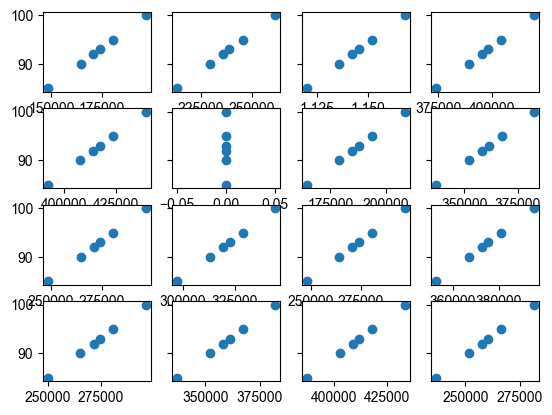

[0.00031115752018482295, 0.00031543309440915, 0.000309636903847359, 0.0003291796376073319, 0.0003197109859134658, 0, 0.0003405961767475169, 0.000327968522426096, 0.0003135882027804418, 0.0003163157794195851, 0.0003073502784930666, 0.00035089582415389687, 0.00032482494035482735, 0.00033225055602919266, 0.0003203543266842367, 0.000331756668292858]


In [801]:
#define the calibration masses (listed as the headers in the calibration csv) and get slopes for each scale
cal_masses=np.array([85,90,92,93,95,100])
scales_slopes=[]
scales_intercept=[]
errors_calibration=[] #list of lists [[error in slope, error in intercept]]
for i in range(0,16):
    if i ==5 and system=='system1':
        scales_slopes+=[0]
        scales_intercept+=[0]
        errors_calibration+=[[0,0]]
    else:
        scale_values=np.array(calibration.iloc[i,1:].values.tolist())
        #print(i)
        output=st.linregress(scale_values,cal_masses)
        scales_slopes+=[output.slope]
        scales_intercept+=[output.intercept]
        errors_calibration+=[[output.stderr,output.intercept_stderr]]

#plot the calibration curves
figure1, ax=plt.subplots(4,4,sharex=False,sharey=True)
for j in range(4):
    for k in range(4):
        i=(j*4)+k
        print(i)
        ax[j,k].scatter(np.array(calibration.iloc[i,1:].values.tolist()),cal_masses)
plt.show()
print(scales_slopes)
def convert_to_mass2(file_name,slopes,intercepts):
    cell_=pd.read_csv('./'+file_name+'.csv',header=0)

    mass_data=cell_
    #print(mass_data)
    for i in range(1,17,1):
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2])
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]*slopes[i-1])
        mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]=mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]*slopes[i-1]+intercepts[i-1]
        #print(mass_data)

    normalization=mass_data.iloc[0,:].to_numpy()
    #print(normalization)
    #get an updated matrix
    update1=mass_data.apply(lambda x: x-normalization, axis=1)
    return update1

In [682]:
#nylon, polyimide, cellulose, PET run
name='with_watchdogandmac_edits_2'
data=convert_to_mass(name)
data_roll=data.rolling(window=50, min_periods=1).mean()
print(data)
print(data_roll)


[0.00031042172100956197, 0.00031465807989590586, 0.0003095057598385496, 0.0003283685062630989, 0.0003185160126255299, 0.00032031257221868927, 0.0003400872065436339, 0.00032722766497132673, 0.00031315962443639205, 0.0003160036480609326, 0.00030745500500710545, 0.000350585724501009, 0.00032463606766239034, 0.0003326887446016757, 0.00031998102805897924, 0.00033162341550175515]
      time_1   Nylon_1  time_2   Nylon_2  time_3   Nylon_3  time_4   Nylon_4  \
0        0.0  0.000000     0.0  0.000000     0.0  0.000000     0.0  0.000000   
1        2.0 -0.016763     2.0 -0.003052     2.0  0.007738     2.0  0.018224   
2        4.0 -0.014621     4.0 -0.009786     4.0 -0.021665     4.0 -0.016254   
3        6.0 -0.020022     6.0 -0.002832     6.0 -0.018880     6.0 -0.010935   
4        8.0 -0.014248     8.0 -0.017275     8.0  0.000619     8.0 -0.014744   
...      ...       ...     ...       ...     ...       ...     ...       ...   
3999  8046.0 -0.471841  8046.0 -0.410597  8046.0 -0.472615  804

In [802]:
data=convert_to_mass2(name, scales_slopes,scales_intercept)
data_roll=data.rolling(window=50, min_periods=1).mean()
print(data)
print(data_roll)

       time 1  PET_0.03mm1   time 2  PGA-commercial-1   time 3  \
0         0.0     0.000000      0.0          0.000000      0.0   
1         2.0    -0.016958      2.0         -0.020945      2.0   
2         4.0    -0.021625      4.0         -0.020156      4.0   
3         6.0    -0.037463      6.0         -0.036685      6.0   
4         8.0    -0.048758      8.0         -0.046242      8.0   
...       ...          ...      ...               ...      ...   
8647  17294.0    -0.158535  17294.0         -2.528890  17294.0   
8648  17296.0    -0.151565  17296.0         -2.531698  17296.0   
8649  17298.0    -0.156201  17298.0         -2.537281  17298.0   
8650  17300.0    -0.150102  17300.0         -2.526272  17300.0   
8651  17302.0    -0.147800  17302.0         -2.528764  17302.0   

      Asics-goretex_1   time 4  Asics-goretex_2  time 5   Asics-goretex_3  \
0            0.000000      0.0         0.000000      0.0         0.000000   
1            0.000619      2.0        -0.016887      

start defining values needed for the Kalman filter - state variables and variances

In [803]:
#x is the state variable - x=[mass, mass loss]. Start with t=2 value for mass and
#0 for the loss
def kalman_filtering(dataset,dt):
    #we need to write the state transition function F. You need an equation to transition from each prior to the updated state. for mass this would be mass=mass+dt*massloss
        #for the mass loss, it should be the same. so massloss=1*massloss
    #dt is your time collection rate, so 2 min, input into the function
    F=np.array([[1.,dt,0.5*dt**2],
                [0.,1.,dt],
                [0.,0.,1.]])
    #the noise covariance is Q. This is the process noise. We have some amount of process noise, from disturbances to the humidity in the chamber. This is initially modeled by just a gaussian white noise estimate. It should be pretty small though so set variance to 0.1
    Q = Q_discrete_white_noise(dim=3, dt=2., var=10)
    #we aren't actively using this information for control updates like steering, so B and u are zero
    B=0.
    u=0
    #H is the conversion between measurement and state (we only measure mass but state has mass and mass loss, and change in mass loss)
    H=np.array([[1.,0.,0]])
    #z is your measurement, here, our mass measurements.
    summary_xs=[0]*16
    summary_cov=[0]*16
    for i in range(0,16):
        names=list(dataset.columns)
        #print(dataset.iloc[0][names[2*i+1]])
        x0=np.array([dataset.iloc[0][names[2*(i)+1]],0,0])
        #P is the state covariance matrix. This gets updated during the processing, and just needs to be set to reasonable values
        #say the variance in mass is 1% of the initial mass, and variance in mass loss is 0.1
        P=np.diag([0.1,0.01,0.01])
        #to build the model we now just need an estimate of the error in the measurements, which we are going to estimate as the stderr of the linear regressing slope. We are going to just use 500 points in the middle of our collection region for this.
        mass = dataset.iloc[100:150, 2 * (i) + 1:2 * (i) + 2].to_numpy()
        time = dataset.iloc[100:150, 2 * (i):2 * (i) + 1].to_numpy()
        mass=np.reshape(mass,-1)
        time=np.reshape(time,-1)
        print(mass,time)
        output=st.linregress(time, mass)
        y_predict=output.slope*time+output.intercept
        residuals=np.abs(mass-y_predict)
        R=np.mean(residuals)

        #print(R)


        kf=KalmanFilter(dim_x=3,dim_z=1)
        kf.x=x0
        kf.F=F
        kf.H=H
        kf.R=R
        kf.P=P
        kf.Q=Q
        # run the kalman filter and store the results
        xs, cov = [], []
        for z in dataset[names[2*i+1]]:
            kf.predict()
            kf.update(z)
            xs.append(kf.x)
            cov.append(kf.P)

        xs, cov = np.array(xs), np.array(cov)
        summary_xs[i]=[xs]
        summary_cov[i]=[cov]
    return [summary_xs,summary_cov]

In [804]:
print(data)
controls_1=kalman_filtering(data,2)
controls_roll=kalman_filtering(data_roll,2)
print (controls_roll[0][0][0][:,0])

       time 1  PET_0.03mm1   time 2  PGA-commercial-1   time 3  \
0         0.0     0.000000      0.0          0.000000      0.0   
1         2.0    -0.016958      2.0         -0.020945      2.0   
2         4.0    -0.021625      4.0         -0.020156      4.0   
3         6.0    -0.037463      6.0         -0.036685      6.0   
4         8.0    -0.048758      8.0         -0.046242      8.0   
...       ...          ...      ...               ...      ...   
8647  17294.0    -0.158535  17294.0         -2.528890  17294.0   
8648  17296.0    -0.151565  17296.0         -2.531698  17296.0   
8649  17298.0    -0.156201  17298.0         -2.537281  17298.0   
8650  17300.0    -0.150102  17300.0         -2.526272  17300.0   
8651  17302.0    -0.147800  17302.0         -2.528764  17302.0   

      Asics-goretex_1   time 4  Asics-goretex_2  time 5   Asics-goretex_3  \
0            0.000000      0.0         0.000000      0.0         0.000000   
1            0.000619      2.0        -0.016887      

In [678]:
print(st.linregress(data_roll['time_1'][0*val:(0+1)*val],controls_roll[0][0][0][:,0][0*val:(0+1)*val]))

KeyError: 'time_1'

In [805]:
# use the rolling average filtered data to get averaged slopes
slopes_filtered=[]

val=50
for i in range(16):
    cell=[]

    for j in range(25,len(data_roll.index)-100,10):
        print(i,j)
        #print(controls_roll[0][i][0][:,0][j*val:(j+1)*val])
        cell+=[st.linregress(data_roll['time 1'][j-25:j+25],controls_roll[0][i][0][:,0][j-25:j+25]).slope]
    slopes_filtered+=[cell]
datatimes=[]
for j in range(25,len(data_roll.index)-50,10):
    print(j)
    datatimes+=[np.average(data_roll['time 1'][j-25:j+25])]



0 25
0 35
0 45
0 55
0 65
0 75
0 85
0 95
0 105
0 115
0 125
0 135
0 145
0 155
0 165
0 175
0 185
0 195
0 205
0 215
0 225
0 235
0 245
0 255
0 265
0 275
0 285
0 295
0 305
0 315
0 325
0 335
0 345
0 355
0 365
0 375
0 385
0 395
0 405
0 415
0 425
0 435
0 445
0 455
0 465
0 475
0 485
0 495
0 505
0 515
0 525
0 535
0 545
0 555
0 565
0 575
0 585
0 595
0 605
0 615
0 625
0 635
0 645
0 655
0 665
0 675
0 685
0 695
0 705
0 715
0 725
0 735
0 745
0 755
0 765
0 775
0 785
0 795
0 805
0 815
0 825
0 835
0 845
0 855
0 865
0 875
0 885
0 895
0 905
0 915
0 925
0 935
0 945
0 955
0 965
0 975
0 985
0 995
0 1005
0 1015
0 1025
0 1035
0 1045
0 1055
0 1065
0 1075
0 1085
0 1095
0 1105
0 1115
0 1125
0 1135
0 1145
0 1155
0 1165
0 1175
0 1185
0 1195
0 1205
0 1215
0 1225
0 1235
0 1245
0 1255
0 1265
0 1275
0 1285
0 1295
0 1305
0 1315
0 1325
0 1335
0 1345
0 1355
0 1365
0 1375
0 1385
0 1395
0 1405
0 1415
0 1425
0 1435
0 1445
0 1455
0 1465
0 1475
0 1485
0 1495
0 1505
0 1515
0 1525
0 1535
0 1545
0 1555
0 1565
0 1575
0 1585
0 1595


0 10 0
0 10 0


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1 10 0
1 10 0


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


2 10 0
2 10 442


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


3 43 0
3 43 372


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


4 10 0
4 10 317


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


5 10 0
5 10 0


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


6 10 0
6 10 0


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


7 13 0
7 13 0


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


8 10 0
8 10 682


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


9 10 0
9 10 782


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


10 10 0
10 10 602


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


11 22 0
11 22 657


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


12 14 0
12 14 262


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


13 10 0
13 10 287


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


14 14 0
14 14 262


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


15 23 0
15 23 0


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/771581013.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


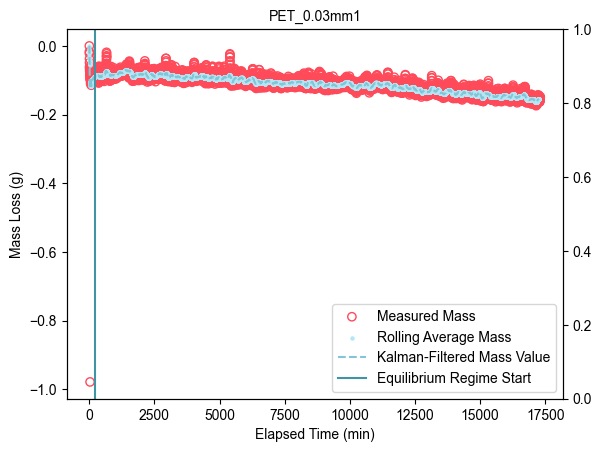

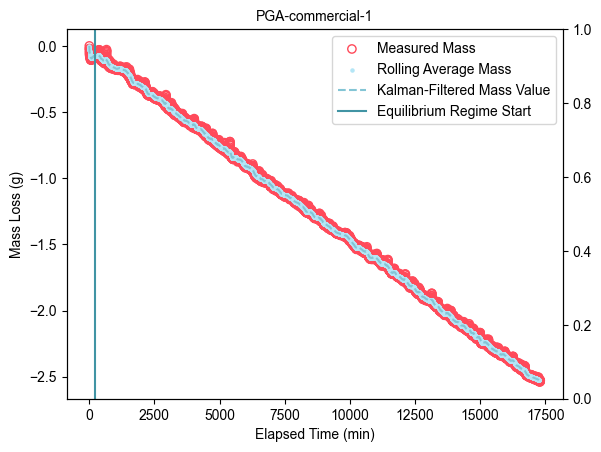

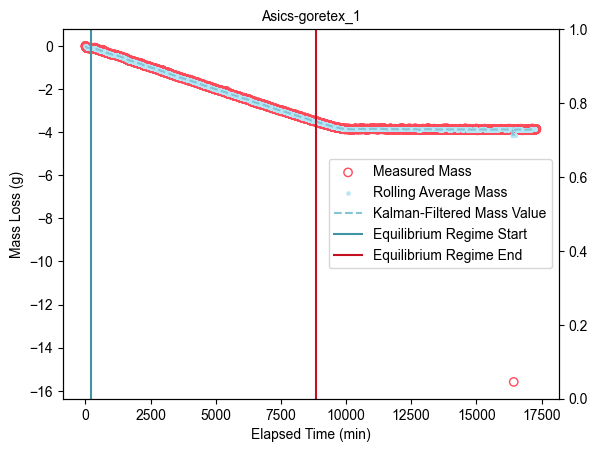

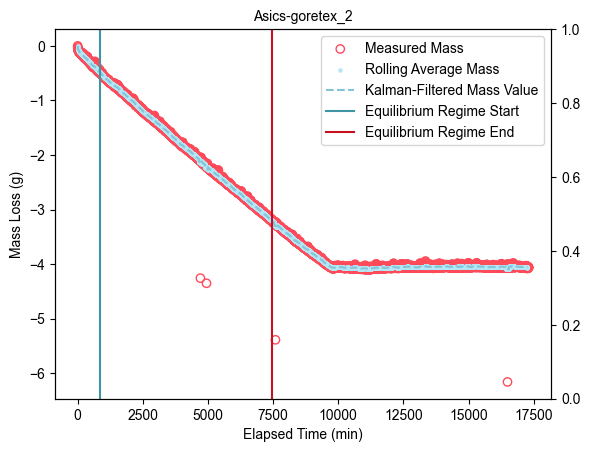

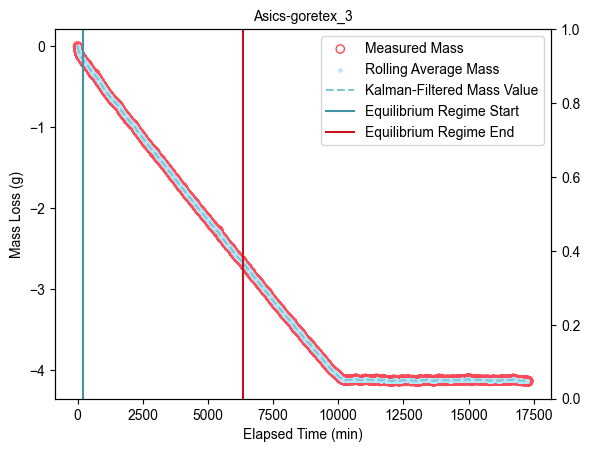

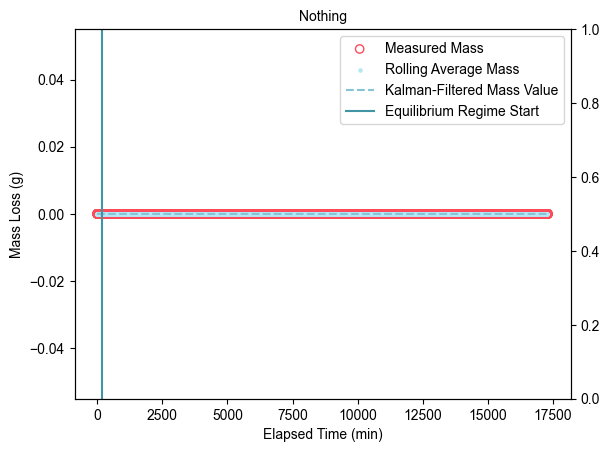

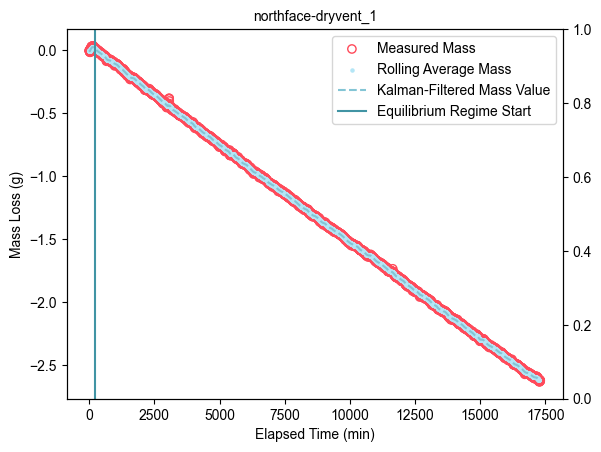

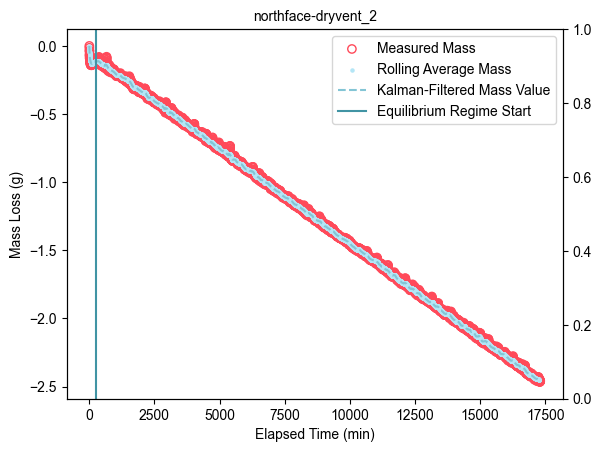

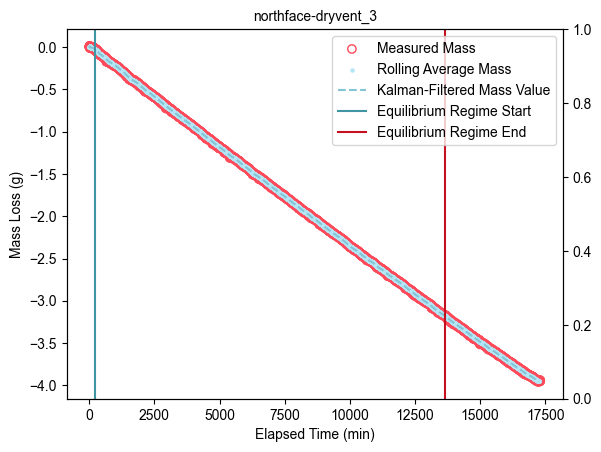

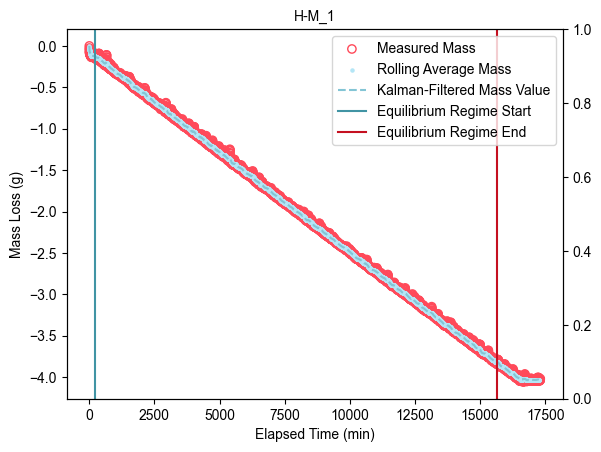

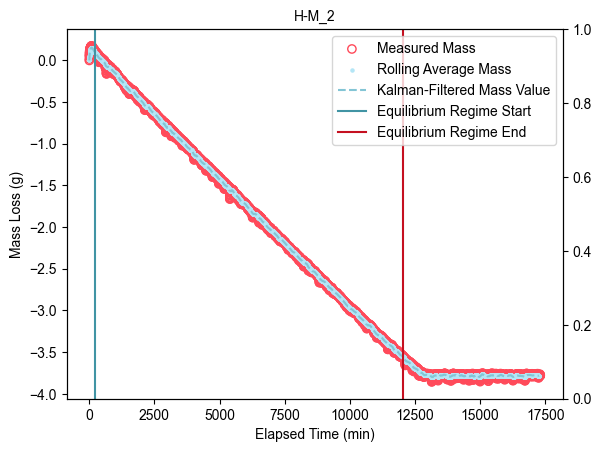

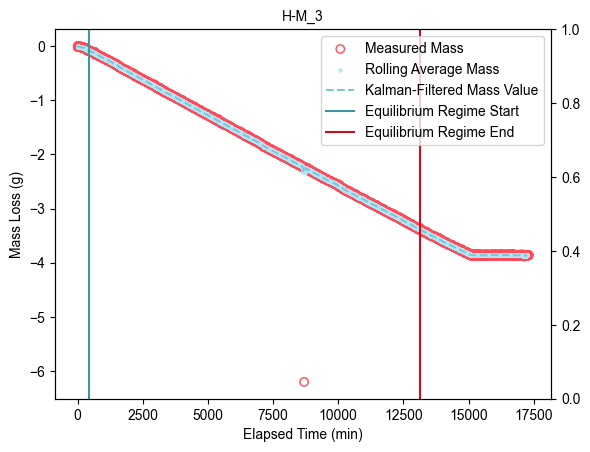

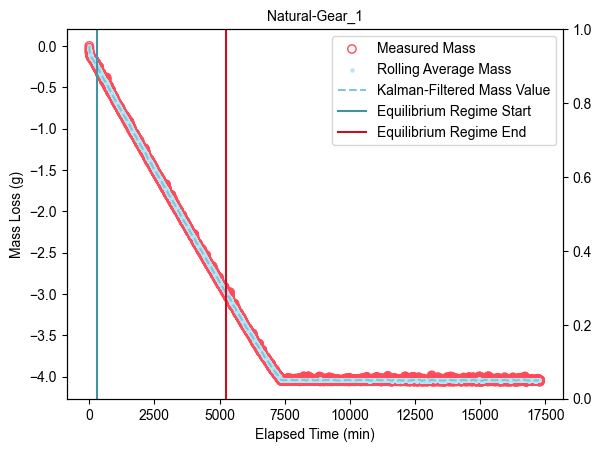

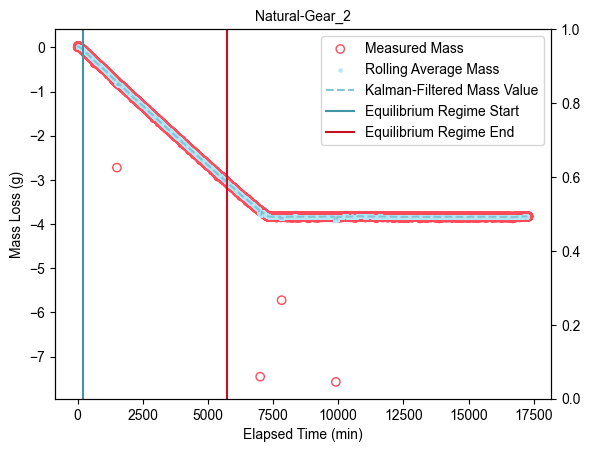

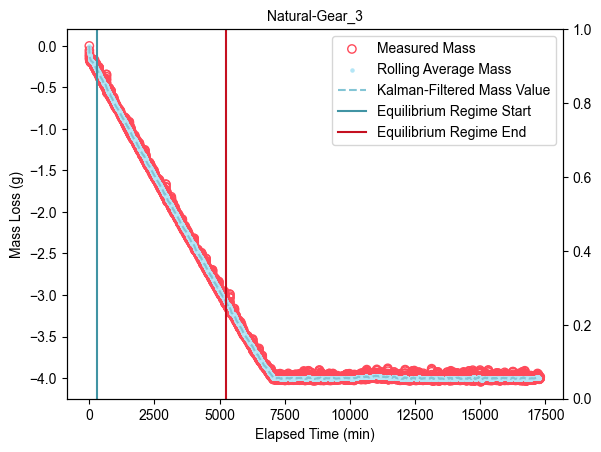

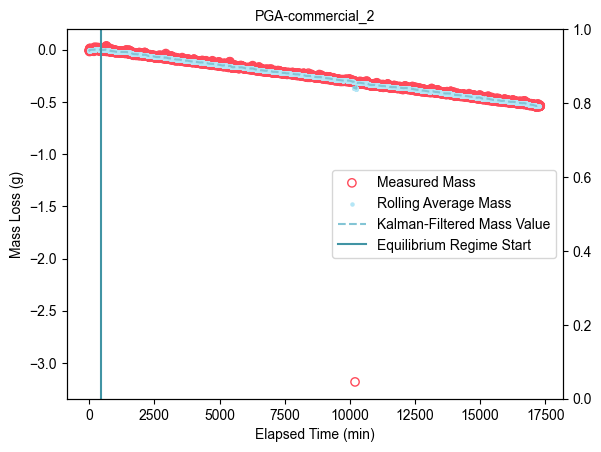

In [806]:
data_ranges=[]
purples=['#8b73d5','#735aac','#393952']
blues=['#b4e6f6','#83c5d5','#4194a4']
gray='#7b8bb4'
pinks=['#ff94ac','#ff4a5a','#c51020']
plt.rcParams["font.family"] = "Arial"
equilibration_start=[]
equilibration_end=[]

for i in range(16):
    fig,ax = plt.subplots()
    ax.scatter(data['time 1'],data[list(data.columns)[2*i+1]],label = 'Measured Mass',facecolors='none',edgecolors=pinks[1], marker='o')
    ax.scatter(data_roll['time 1'],data_roll[list(data.columns)[2*i+1]],label = 'Rolling Average Mass',color=blues[0],s=5)
    ax.plot(data_roll['time 1'],controls_roll[0][i][0][:,0],linestyle='--',label='Kalman-Filtered Mass Value',color=blues[1])
    ax2=ax.twinx()
    #ax2.scatter(datatimes[0:100],slopes_filtered[i][0:100],color='black')
    average=np.average(slopes_filtered[i][50:200])
    residuals=(average-slopes_filtered[i])
    #ax2.scatter(datatimes[:len(residuals)],residuals,label='Kalman-Filtered Mass Residual',color=purples[1])
    linear=0
    linear_end=0
    for k in range(10,len(residuals)-55,1):
        #print(k,linear,linear_end)
        if linear==0:
            pos=sum(x>=0 for x in residuals[k:k+15])
            neg=sum(x<=0 for x in residuals[k:k+15])
            #print(pos,neg)
            if abs(pos-neg)<=5:
                linear=k
                new_average=np.average(slopes_filtered[i][k:k+100])
                residuals=new_average-slopes_filtered[i]

            else:
                pass
    print(i,linear,linear_end)
    if abs(new_average*datatimes[len(datatimes)-1])>3:
        #print(abs(new_average*datatimes[len(datatimes)-1]))
        for l in range(len(residuals)-1,0,-5):
                #print(l)
                pos=sum(x>=0 for x in residuals[l-20:l])
                neg=sum(x<=0 for x in residuals[l-20:l])
                if linear_end==0 and abs(pos-neg)<=2:
                    linear_end=l-20
               # print(pos,neg)
                else:
                    pass

    print(i,linear,linear_end)

    ax.axvline(x=datatimes[linear],color=blues[2],label='Equilibrium Regime Start')
    if linear_end!=0:
        ax.axvline(x=datatimes[linear_end], color=pinks[2],label='Equilibrium Regime End')
        equilibration_end+=[datatimes[linear_end]]
    elif linear_end==0:
        equilibration_end+=[0]
    equilibration_start+=[datatimes[linear]]


    ax.set_xlabel('Elapsed Time (min)',fontsize=10)
    ax.set_ylabel('Mass Loss (g)',fontsize=10)
    #ax.set_ylim([-0.5,0.5])
    #ax.set_xlim([0,1000])
    #ax2.set_ylabel('Rate of Mass Loss, Residual (g/min)', fontsize=10)
    ax.set_title(list(data.columns)[2*i+1],fontsize=10)
    ax.legend(fontsize=10)
    plt.savefig('./'+name+'/'+str(list(data.columns)[2*i+1])+'_equilibrium'+'.pdf',dpi=300)

    fig.show()
equilibration_start=np.array(equilibration_start)
equilibration_end=np.array(equilibration_end)

np.save('./'+name+'/equilibration_start',equilibration_start,allow_pickle=False)
np.save('./'+name+'/equilibration_end',equilibration_end,allow_pickle=False)

[200. 200. 200. 860. 200. 200. 200. 260. 200. 200. 200. 440. 280. 200.
 280. 460.]
[    0.     0.  8840.  7440.  6340.     0.     0.     0. 13640. 15640.
 12040. 13140.  5240.  5740.  5240.     0.]
100
end 0.0
       time 1  PET_0.03mm1
100     200.0    -0.081274
101     202.0    -0.073309
102     204.0    -0.071722
103     206.0    -0.071877
104     208.0    -0.084013
...       ...          ...
8647  17294.0    -0.158535
8648  17296.0    -0.151565
8649  17298.0    -0.156201
8650  17300.0    -0.150102
8651  17302.0    -0.147800

[8552 rows x 2 columns]
[1.1320950842567454, 1.6630577100349626, 1.5252959328912725, 1.539140241882965, 0.8030460065570103, 0.44721300990084434, 0.34938781846736555, 0.008224616686862807, 0.019288488622857147, 0.03413653444502085, 0.03852124176213467, 0.35037406078981714, 0.06693397560887593, 0.0027575324614046437, 0.03470731967741958, 0.407659868494465, 0.9589286685694982, 0.2126082668881093, 0.11519750553791297, 0.8111973327332698, 1.145628813818004, 0.437208

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


100
end 0.0
       time 2  PGA-commercial-1
100     200.0         -0.051920
101     202.0         -0.049334
102     204.0         -0.045359
103     206.0         -0.056652
104     208.0         -0.059238
...       ...               ...
8647  17294.0         -2.528890
8648  17296.0         -2.531698
8649  17298.0         -2.537281
8650  17300.0         -2.526272
8651  17302.0         -2.528764

[8552 rows x 2 columns]
[1.6472767258165844, 1.7780814648448726, 1.5807729372527963, 1.4094382842017863, 1.2397496273993691, 0.6857030358229808, 0.2949548893902848, 0.4424895658496144, 0.6318854910562638, 0.014925698349919525, 0.10517580474706367, 0.09542197845258515, 0.19192121988535016, 0.04392960176765426, 0.24898003217645026, 0.31655636607555226, 0.3707308476063784, 0.3493221458904636, 0.7681051113348553, 1.2659881648777045, 0.6342950903664786, 0.18898676220823696, 0.2665283815703008, 0.23772067594809, 0.06493114067108874, 0.11282526615882171, 0.3319567439036639, 0.17487444005252584, 0.065875

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


100
end 8840.0
      time 3  Asics-goretex_1
100    200.0        -0.101251
101    202.0        -0.085150
102    204.0        -0.072145
103    206.0        -0.082363
104    208.0        -0.093510
...      ...              ...
4415  8830.0        -3.462050
4416  8832.0        -3.462050
4417  8834.0        -3.485273
4418  8836.0        -3.492704
4419  8838.0        -3.501993

[4320 rows x 2 columns]
[0.05455409727283633, 0.8051220001755688, 1.73815134660755, 1.1497567940476054, 0.40287626239483654, 0.5260312332541045, 0.07472447975216301, 0.17229049414542974, 0.7618476403891227, 0.06429320464280597, 0.24742250349117878, 0.03947854828905184, 0.17204720446214106, 0.4632335422558458, 1.3032259541336733, 1.2710733402502585, 0.3881878878460041, 0.38138871967236243, 0.9773698910470561, 1.6534897450727262, 0.6291428365070568, 0.2543195033853891, 0.793126181331055, 0.06576352132513186, 0.26449471319631757, 0.17923503949800335, 0.02105306693035791, 0.05480062954582188, 0.03694683465472348, 0.10134

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


430
end 7440.0
       time 4  Asics-goretex_2
430     860.0        -0.488305
431     862.0        -0.490609
432     864.0        -0.491366
433     866.0        -0.481129
434     868.0        -0.497456
...       ...              ...
3715   7430.0        -3.202161
3716   7432.0        -3.194458
3717   7434.0        -3.180567
3718   7436.0        -3.170000
3719   7438.0        -3.174246

[3290 rows x 2 columns]
[0.8870917990902956, 0.9086870595445382, 0.9077370962496278, 0.7493136736515327, 0.9728483137086967, 1.0593696693059624, 1.0255767560859272, 1.0622849128165797, 0.936680996552441, 0.7966885148420556, 0.8471439506913634, 0.9608447371202389, 0.9232353244194162, 0.9541054068290942, 1.0734446584677655, 0.9628208901752994, 1.08742037035922, 1.1123817778823564, 1.0908064734203897, 1.0078291599969607, 0.6652618240346637, 0.7112236304565124, 0.7107823210955959, 0.9195051429743487, 1.0156212855004743, 1.0383492833852128, 1.120613403738933, 0.9673009341685236, 0.9943863065054012, 0.959109850

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


100
end 6340.0
      time 5   Asics-goretex_3
100     200.0        -0.163596
101     202.0        -0.168200
102     204.0        -0.168839
103     206.0        -0.166218
104     208.0        -0.171813
...       ...              ...
3165   6330.0        -2.659963
3166   6332.0        -2.662425
3167   6334.0        -2.662233
3168   6336.0        -2.668276
3169   6338.0        -2.668660

[3070 rows x 2 columns]
[0.003006007855636761, 0.016894530474461877, 0.01570395596845675, 0.0032821571916464842, 0.02705976143879163, 0.010341347677390256, 0.003694711762775693, 0.028996914036455546, 0.0157296629002861, 0.02497013361604339, 0.2659076018111306, 0.3207445202240615, 0.2338955525980212, 0.044714623190143854, 0.23016223135508618, 0.1440680661923054, 0.018726970746559157, 0.007688636223603829, 0.13436866608648257, 0.05815306329898162, 0.13697778525968518, 0.22948557659450064, 0.22670027271842141, 0.10294524025415608, 0.476984815400222, 0.6774469311827129, 0.2624140232750256, 0.7689076622217241,

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


100
end 0.0
       time 6  Nothing
100     200.0      0.0
101     202.0      0.0
102     204.0      0.0
103     206.0      0.0
104     208.0      0.0
...       ...      ...
8647  17294.0      0.0
8648  17296.0      0.0
8649  17298.0      0.0
8650  17300.0      0.0
8651  17302.0      0.0

[8552 rows x 2 columns]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


100
end 0.0
       time 7  northface-dryvent_1
100     200.0             0.007868
101     202.0             0.007663
102     204.0             0.009673
103     206.0             0.016212
104     208.0             0.011648
...       ...                  ...
8647  17294.0            -2.627836
8648  17296.0            -2.624225
8649  17298.0            -2.626916
8650  17300.0            -2.628823
8651  17302.0            -2.625077

[8552 rows x 2 columns]
[0.4500155442574303, 0.43934652992044854, 0.24245144473924973, 0.019426245122687313, 0.10708699876517824, 0.005342817261005162, 0.11334689170207823, 0.029520501768635743, 0.0020870688841433394, 0.26773016316564824, 0.011906650881860159, 0.006553112585978016, 0.09892191120907778, 0.03341737532310429, 0.02200968541847148, 0.012629774111418524, 0.04480882125353425, 0.07890514519702474, 0.010662295201590788, 0.0617027658586945, 0.021844446499535763, 0.19762791811221714, 0.00038660564371006956, 0.012091000912309302, 0.043188714091403235, 0.11

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


130
end 0.0
       time 8  northface-dryvent_2
130     260.0            -0.116855
131     262.0            -0.129187
132     264.0            -0.120168
133     266.0            -0.107279
134     268.0            -0.103572
...       ...                  ...
8647  17294.0            -2.460321
8648  17296.0            -2.462027
8649  17298.0            -2.454943
8650  17300.0            -2.459010
8651  17302.0            -2.459764

[8522 rows x 2 columns]
[0.0521099180837411, 0.0002601661164699509, 0.019639974426880147, 0.6417226819547364, 1.0795816136666705, 1.4300869558544043, 0.6742041408227548, 1.6937898940765486, 1.556384790192641, 1.1908136689147568, 1.0644810048838949, 0.5326289986801842, 0.4520486974707777, 0.6050692460186974, 0.14576773550035016, 0.03834476408250642, 0.08129463547693305, 0.07614103596304223, 0.17032374442417997, 0.1799238549612684, 0.4517327793649044, 0.7262153750202726, 0.8861328770527805, 1.614949032931547, 1.2700328040177182, 1.3835994290973286, 0.727715116663

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


100
end 13640.0
      time 9   northface-dryvent_3
100     200.0            -0.033617
101     202.0            -0.030418
102     204.0            -0.029101
103     206.0            -0.023206
104     208.0            -0.023331
...       ...                  ...
6815  13630.0            -3.176743
6816  13632.0            -3.171757
6817  13634.0            -3.170722
6818  13636.0            -3.177871
6819  13638.0            -3.168746

[6720 rows x 2 columns]
[0.2373424326641489, 0.08542730669243603, 0.047460040691088334, 0.0035401310194767, 0.0030087685658822805, 0.02023128707846833, 0.011592095819515702, 0.008425103822207958, 0.00013995834330804424, 0.0012878313362923999, 0.001610769324094874, 0.00016897870051435504, 0.0004923659209171705, 0.010630119729274745, 0.0004078239990881194, 1.983840980024354e-05, 0.004330138784857662, 0.04538474260213954, 0.027246475727016217, 0.0005496194673950683, 0.0011074829606011471, 0.026043684414197243, 4.8610121360481706e-05, 0.0016564722363128226, 6.5

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


100
end 15640.0
       time 10     H-M_1
100      200.0 -0.088948
101      202.0 -0.090783
102      204.0 -0.099260
103      206.0 -0.110173
104      208.0 -0.129974
...        ...       ...
7815   15630.0 -3.810403
7816   15632.0 -3.821917
7817   15634.0 -3.823309
7818   15636.0 -3.826504
7819   15638.0 -3.826472

[7720 rows x 2 columns]
[0.04478286032699197, 0.058284610981947815, 0.2205530101290476, 0.724136008374849, 1.6422438914635396, 1.6913580985648822, 1.118129163297949, 0.9734374397139645, 1.2998511797940386, 0.838325215020463, 1.0444254937097095, 1.6190222313449398, 1.629312536155997, 1.6380375653037853, 1.5214150249004725, 1.08407096663738, 0.8795525330408048, 0.6654238598711353, 1.192760580092255, 1.113644800832637, 1.4155904203140146, 1.269933397500128, 1.4721075687719658, 1.5424431951656286, 1.403365151146211, 0.8683995407280407, 0.4810585048232232, 1.248583972212761, 0.6741365251578175, 0.7939179094229969, 1.3092551206074718, 1.6472877229407037, 0.9877603163543603, 0.0633

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


100
end 12040.0
      time 11     H-M_2
100     200.0  0.087257
101     202.0  0.074778
102     204.0  0.072043
103     206.0  0.079634
104     208.0  0.082185
...       ...       ...
6015  12030.0 -3.545531
6016  12032.0 -3.551648
6017  12034.0 -3.550633
6018  12036.0 -3.547437
6019  12038.0 -3.557641

[5920 rows x 2 columns]
[0.6623751215311562, 1.4065434610653815, 1.5204607304305542, 1.0280864218398458, 0.8226293975035112, 0.44714167041709274, 0.12849844036100455, 0.1252879121536391, 0.03199876233379939, 0.10650925133737132, 0.002483587575077828, 0.008087194829937139, 0.0261689036919317, 0.16028107063228214, 0.10834989331217448, 0.017284218740521218, 0.031194715855830335, 0.34843031021827864, 0.29204082053272984, 0.2411219729040628, 0.3022256852051123, 0.2858776611398034, 0.10888319853364681, 0.07230142207387102, 0.04900333452295069, 0.016217370169869683, 0.03336521022770178, 0.003122362923593691, 0.004167290797790546, 0.014263368658520403, 0.0013023915431883415, 0.02200668624322999

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


220
end 13140.0
       time 12     H-M_3
220      440.0 -0.076530
221      442.0 -0.083548
222      444.0 -0.088952
223      446.0 -0.087233
224      448.0 -0.086496
...        ...       ...
6565   13130.0 -3.379267
6566   13132.0 -3.367828
6567   13134.0 -3.359020
6568   13136.0 -3.365617
6569   13138.0 -3.374074

[6350 rows x 2 columns]
[0.967070599225916, 1.0707806077629636, 1.0773724231217472, 1.1126906003316694, 1.092737712123848, 1.0866530253928355, 1.0943860319086758, 1.0415400822768692, 1.0918929247981035, 1.0226247815936773, 0.9459099367245648, 1.0541255704116548, 1.1034424366834412, 1.0598542609126487, 1.035731809324651, 1.0812150145284258, 1.0898135698040283, 1.0958730383910522, 1.0243555202340655, 1.008164250586824, 1.0664764031592147, 1.0492057918803628, 1.0391949386550365, 1.0160661595611749, 1.0825845307995592, 1.0997174729661086, 1.0382805222514735, 1.098540069006102, 1.0426256414778639, 0.9305098362617539, 1.0564826924495914, 1.1038338283598472, 1.06169729771874, 1.096

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


140
end 5240.0
      time 13   Natural-Gear_1
140      280.0       -0.238909
141      282.0       -0.246802
142      284.0       -0.248913
143      286.0       -0.252162
144      288.0       -0.257554
...        ...             ...
2615    5230.0       -2.983647
2616    5232.0       -2.995308
2617    5234.0       -2.987318
2618    5236.0       -2.979164
2619    5238.0       -2.984784

[2480 rows x 2 columns]
[0.1913001292071258, 0.5659412414541012, 0.6417388049493818, 0.8151283451463981, 1.181118945939538, 1.183925889060066, 0.5498149166796545, 1.132010741152493, 1.1210495252932757, 1.4404784687505536, 0.46275909951657423, 0.15936510308762308, 0.0365617197374396, 0.02811526478032933, 0.028885116998158544, 0.09156514622331924, 0.476072522137752, 0.3634454205608132, 0.8000893860447843, 1.0692369203745398, 0.24003678678577323, 0.19087792996642083, 0.5462925582604186, 0.8496236845226384, 0.68157034722993, 0.946820752497477, 1.005599555870032, 0.451142365032581, 0.7025737506060626, 0.246087

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


100
end 5740.0
       time 14  Natural-Gear_2
100      200.0       -0.069474
101      202.0       -0.072863
102      204.0       -0.071334
103      206.0       -0.063227
104      208.0       -0.066915
...        ...             ...
2865    5730.0       -3.047734
2866    5732.0       -3.050392
2867    5734.0       -3.051123
2868    5736.0       -3.053183
2869    5738.0       -3.065742

[2770 rows x 2 columns]
[1.1371739475663252, 1.185261207132109, 1.1307313836535224, 0.9356340920960219, 0.9910347138772141, 0.7533430342538213, 0.9124919391706366, 0.8769862407894373, 0.7140422877911567, 0.7476455704018078, 0.6061001459141084, 0.6357695939496332, 0.6436232871650808, 0.8792925203850056, 0.7978066007764789, 0.6335770987638845, 0.6845300249933048, 0.8371825517878215, 0.9651165622238763, 0.9159942775129445, 0.9543493722575421, 0.8237175108863796, 0.8412829179984924, 0.845712824075449, 0.7114806897869674, 0.6284246591938593, 0.8050710205026973, 0.7848081870607725, 0.6519922687373447, 0.8113574

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


140
end 5240.0
      time 15  Natural-Gear_3
140     280.0       -0.289312
141     282.0       -0.301325
142     284.0       -0.300012
143     286.0       -0.310616
144     288.0       -0.303376
...       ...             ...
2615   5230.0       -3.100549
2616   5232.0       -3.103433
2617   5234.0       -3.104169
2618   5236.0       -3.100325
2619   5238.0       -3.084628

[2480 rows x 2 columns]
[1.2544868315492819, 1.6580176668123547, 1.5820406187177118, 1.5690574627886287, 1.6177252569518372, 1.5139452239672186, 1.6459318407284806, 1.664395893063734, 1.5314762854849087, 1.5572650540704651, 1.6967075056988117, 0.4096103121446567, 0.0683158598450535, 0.04297324508207245, 0.20893661759779558, 0.7929059222623835, 1.1694604553319643, 1.6826400326246995, 1.6913035340533922, 1.715834674641918, 1.6226805266769615, 1.349790898020748, 0.5134317553045217, 0.9162616493559234, 1.211525116592278, 1.2673435734687137, 1.6223135330092004, 1.5653415985760493, 1.5306495905780384, 0.4123138769670005, 0

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


230
end 0.0
       time 16  PGA-commercial_2
230      460.0          0.011147
231      462.0          0.010882
232      464.0         -0.001128
233      466.0          0.004047
234      468.0         -0.004081
...        ...               ...
8647   17294.0         -0.538176
8648   17296.0         -0.537346
8649   17298.0         -0.539635
8650   17300.0         -0.539038
8651   17302.0         -0.534161

[8422 rows x 2 columns]
[0.8598212677490346, 0.8648495532390221, 1.0951253245003656, 1.0339025389308514, 1.0238550083172604, 1.0539723439839883, 0.9708410637814788, 1.098124213674752, 1.0445535847988747, 0.9822688825405425, 1.0595145503430858, 1.0619419632582856, 1.1119378408638698, 1.0106590260080641, 1.1018207182272892, 0.9091409673297645, 1.0582574353013774, 0.8998388179455344, 1.0027667632633557, 1.0094152449009213, 1.0504504514850614, 1.0159956916644386, 1.0402580956240894, 0.9386874129078477, 1.0115966148742155, 1.0420919777751276, 0.9272669106128467, 0.8682327235738807, 0.85424

/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/3883565758.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


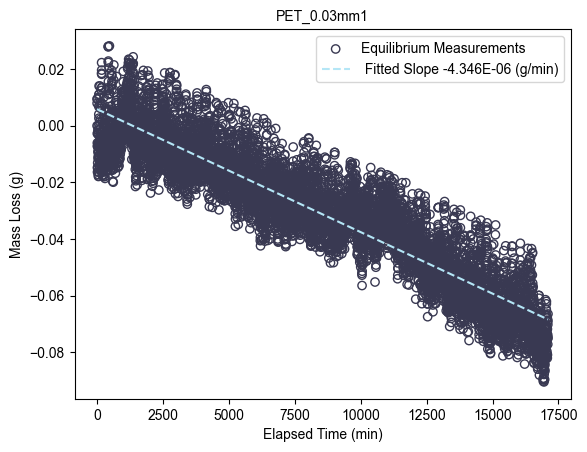

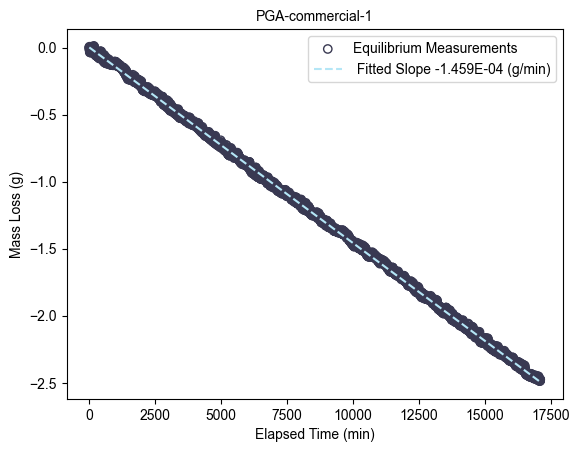

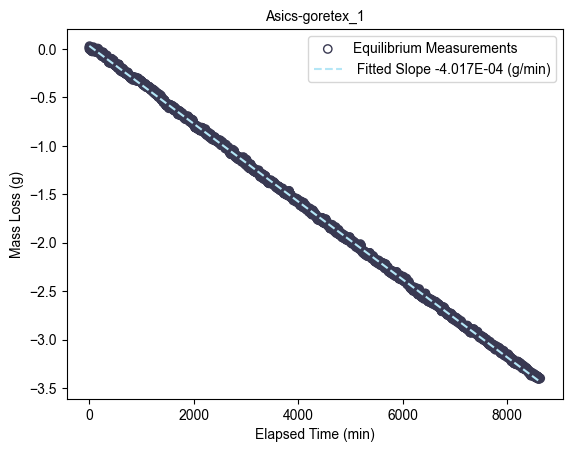

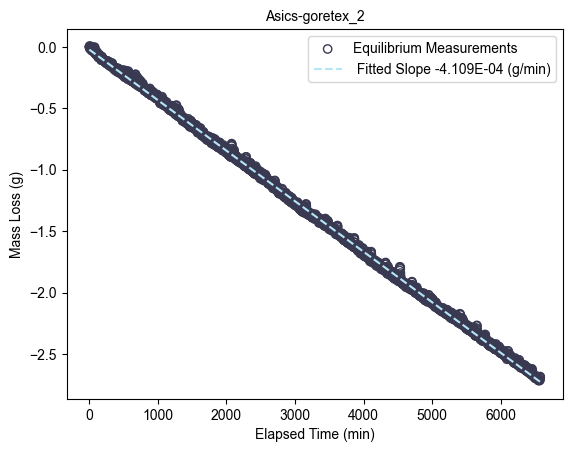

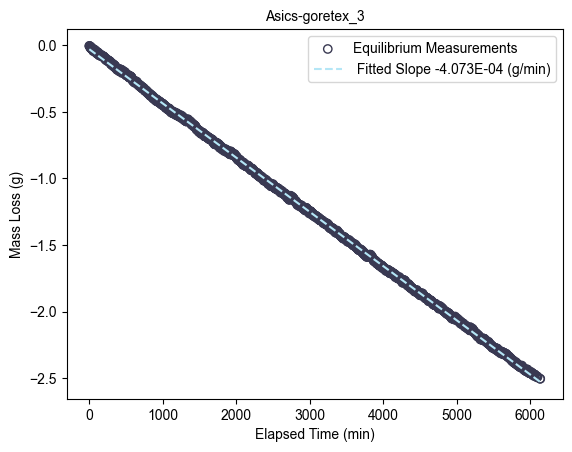

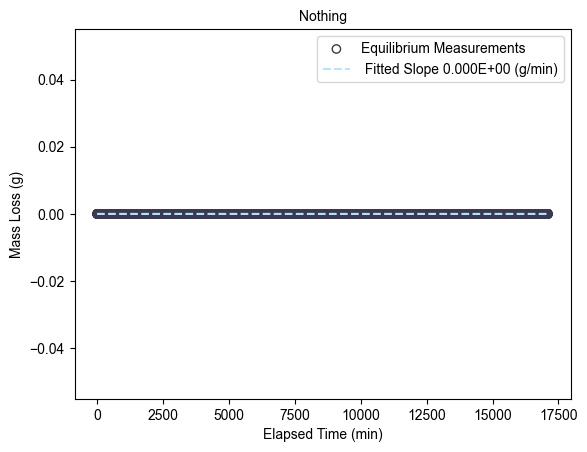

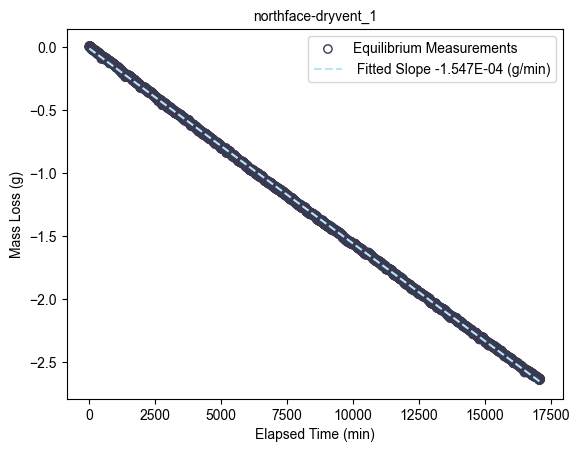

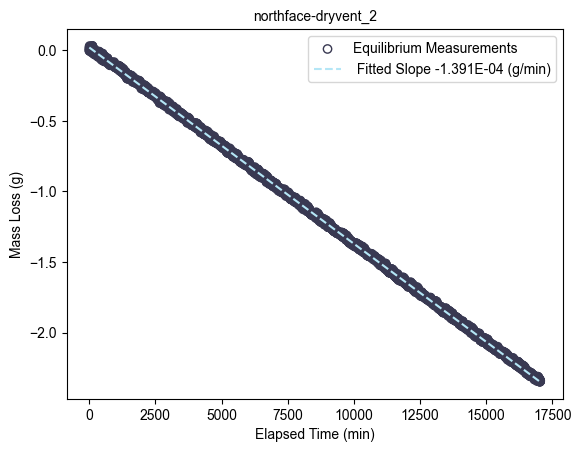

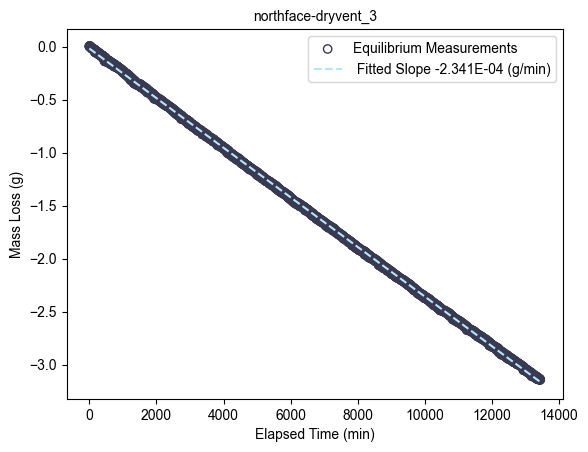

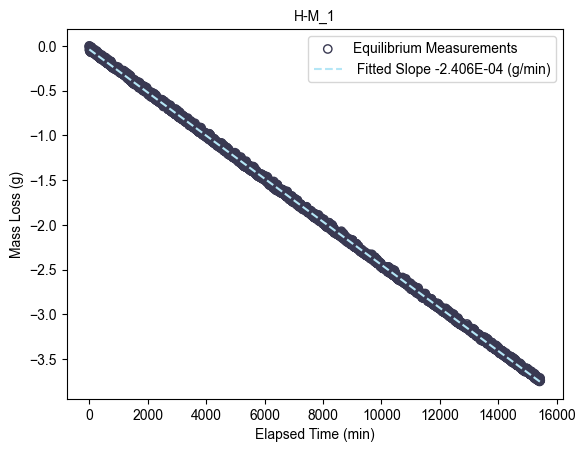

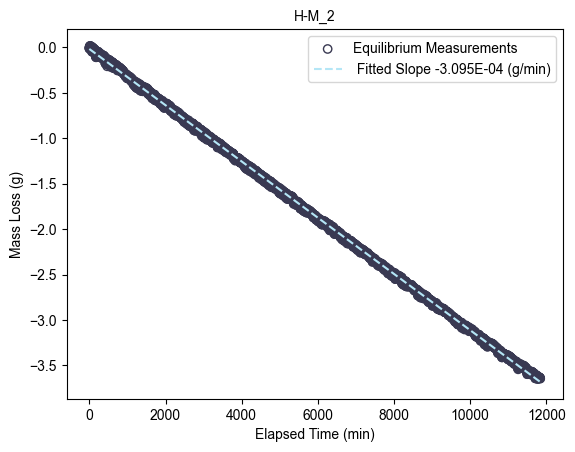

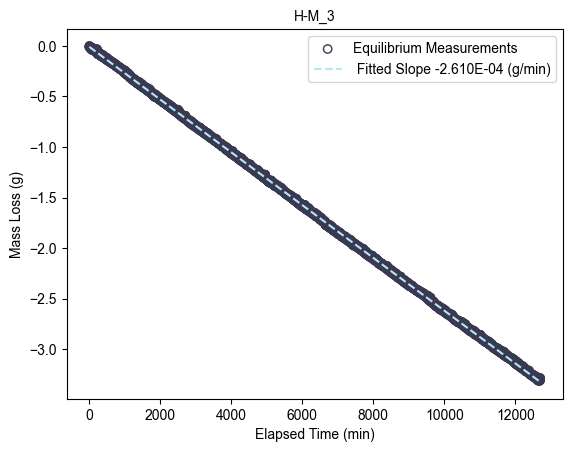

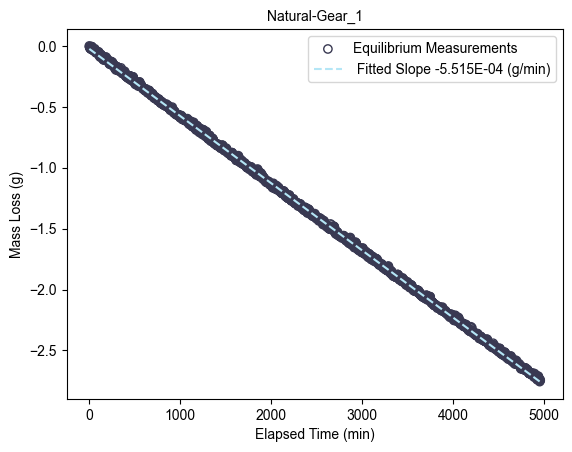

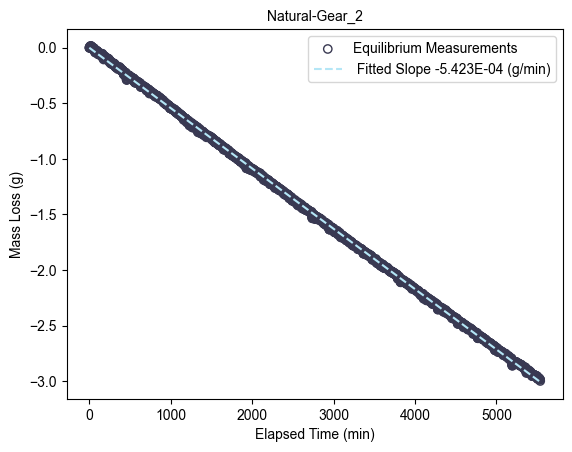

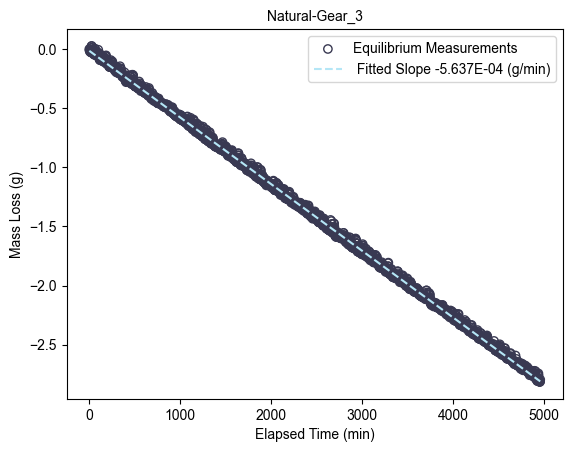

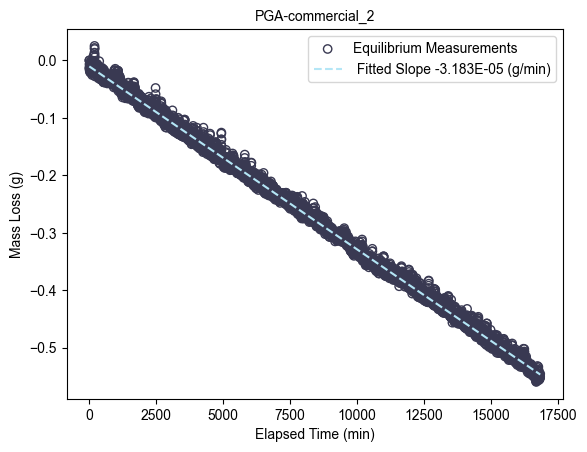

In [811]:
#split up each sample and trim to equilibration regime and save
scale_split=[]
fits=[]
scales=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
print(equilibration_start)
print(equilibration_end)
for i in scales:
    index=int(equilibration_start[i]/2)
    print(index)
    print('end',equilibration_end[i])
    if equilibration_end[i] ==0:
        scale_info=data.iloc[index:,2*i:2*i+2]
        scale_split+=[scale_info]
    elif equilibration_end[i]!=0:
        index2=int(equilibration_end[i]/2)
        scale_info=data.iloc[index:index2,2*i:2*i+2]
        scale_split+=[scale_info]
    #print(scale_info)
    #normalize the data to basically start at zero mass lost and 0 elapsed time
    print(scale_info)
    normalization=scale_info.iloc[0,:].to_numpy()
    #print(normalization)
    #get an updated matrix
    updated=scale_info.apply(lambda x: x-normalization, axis=1)
    output=st.linregress(updated.iloc[:,0],updated.iloc[:,1])
    #get rid of the outliers
    true=updated.iloc[:,0]*output.slope+output.intercept
    values=np.array(abs(updated.iloc[:,1]-true))
    #print(values)
    z_scores=st.zscore(values,ddof=1)
    pvals=[]
    for z in z_scores:
        pvals+=[st.norm.cdf(-z)+1-st.norm.cdf(z)]
    print(pvals)
    outliers=[]
    indexes=updated.index
    for m in range(len(pvals)):
        if pvals[m] <=0.01:
            outliers+=[m]
            updated=updated.drop(index=indexes[m])
    print(outliers)
    #redo the fitting
    output=st.linregress(updated.iloc[:,0],updated.iloc[:,1])
    fit=np.array([output.slope,output.intercept,output.stderr])
    fits+=[fit]
    np.save('./'+name+'/scale'+str(i)+'-'+str(list(scale_info.columns)[1]+'-normalized'),updated.to_numpy(),allow_pickle=False)
    np.save('./'+name+'/scale'+str(i)+'-'+str(list(scale_info.columns)[1]+'-fit'),fit,allow_pickle=False)
    fig,ax = plt.subplots()
    ax.scatter(updated.iloc[:,0],mult*updated.iloc[:,1],marker='o',facecolor='none',edgecolor=purples[2],label='Equilibrium Measurements')
    ax.plot(updated.iloc[:,0],mult*(output.intercept+output.slope*updated.iloc[:,0]),label=" Fitted Slope "+str(f"{fit[0]:.3E}")+" (g/min)",linestyle='--',color=blues[0])
    ax.set_xlabel('Elapsed Time (min)',fontsize=10)
    ax.set_ylabel('Mass Loss (g)',fontsize=10)
    #ax.set_ylim([-5,1])
    #ax2.set_ylabel('Rate of Mass Loss, Residual (g/min)', fontsize=10)
    ax.set_title(list(scale_info.columns)[1],fontsize=10)
    ax.legend(fontsize=10)
    plt.savefig('./'+name+'/'+str(list(scale_info.columns)[1])+'_fitted'+'.pdf',dpi=300)

    fig.show()


In [791]:
print(equilibration_start)
print(equilibration_end)

[ 240.  200.  200.  220.  200.  200.  260.  360.  300.  380.  380.  200.
 1100.  200.  320.  440.]
[   0.    0.    0.    0. 3940. 5440. 5340. 3740. 5840. 5440. 4340. 4440.
 5640. 3940. 2940. 2240.]


In [808]:
#find when endpoint criteria are met for each scale
crits=[0]*16

for k in range(0,16):
    crit1=0
    crit2=0
    crit3=0
    edit=data
    #get number of datapoints collected
    time_edit=data.iloc[:,0:1]
    #start with 500 datapoints
    i=501
    while i < len(edit.index)-1 and crits[k]==0:

        #use last collected 500 datapoints
        a = edit.iloc[(i)-500:i,2*(k)+1:2*(k)+2].to_numpy()
        #The numbers in the file run as every 4 min
        #so when the timepoints are correct in the file use above, when not edit list earlier
        #print(time_edit)
        b=(time_edit.iloc[(i)-500:i,:])
        #b = edit.iloc[:i,2*(k-1):2*(k-1)+1].to_numpy()
        a = np.reshape(a,-1)
        b = np.reshape(b,-1)
        output=st.linregress(b, a)
        #output has attributes output.slope, output.stderr, and more from scipy.stats
        #print(output)
        #for other conditions, make sure there are enough datapoints
        if i>2000:
            #use the last 2000 datapoints to calculate values
            a = edit.iloc[(i)-2000:i,2*(k)+1:2*(k)+2].to_numpy()
            b=(time_edit.iloc[(i)-2000:i])
            #reshaping is to meet dimension constraints of stats package
            a = np.reshape(a,-1)
            b = np.reshape(b,-1)
            output2=st.linregress(b, a)
            #calculations to meet 1000 datapoint requirements
            a = edit.iloc[(i)-1000:i,2*(k)+1:2*(k)+2].to_numpy()
            b=(time_edit.iloc[(i)-1000:i])
            a = np.reshape(a,-1)
            b = np.reshape(b,-1)
            output1=st.linregress(b, a)
        #criteria 1- abs error les than 0.01 for equilibration
        if output.stderr<0.01:
            crit1=1
        #criteria 2- rel error or abs+rel+slope0
        #relative error less than 3%
        if abs(output.stderr/output.slope)<0.03:
            crit2=1
        #OR relative error less than 10%, abs. error less than 0.005, and slope close to 0
        elif i>2000:
            if abs(output2.stderr/output2.slope)<0.1 and output1.stderr<0.005 and abs(output2.slope)<0.05:
                crit2=1
        #check that we are within the min to max number of datapoint collected range
        minpt=48*60/2
        maxpt=7*24*60/2
        if i>minpt: #minimum number of samplings
            crit3=1
        if crit1==1 and crit2==1 and crit3==1:
            crits[k]=i
        #update i, screen every 15 datapoints, or 30 min
        i=i+15
print(crits)


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/1812197439.py:47: RuntimeWarning: invalid value encountered in scalar divide
  if abs(output.stderr/output.slope)<0.03:
/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_22463/1812197439.py:51: RuntimeWarning: invalid value encountered in scalar divide
  if abs(output2.stderr/output2.slope)<0.1 and output1.stderr<0.005 and abs(output2.slope)<0.05:


[2076, 1446, 1446, 1446, 1446, 0, 1446, 1446, 1446, 1446, 1446, 1446, 1446, 1446, 1446, 1446]


In [809]:
#dataprocessing for dynamic time end
print(equilibration_start)
print(equilibration_end)
fits_dynamic=[]
scales=[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15]
for i in scales:
    index=int(equilibration_start[i]/2)
    print(index)
    print('end',equilibration_end[i])
    scale_info=data.iloc[index:crits[i],2*i:2*i+2]
    scale_split+=[scale_info]
    #print(scale_info)
    #normalize the data to basically start at zero mass lost and 0 elapsed time
    print(scale_info)
    normalization=scale_info.iloc[0,:].to_numpy()
    #print(normalization)
    #get an updated matrix
    updated=scale_info.apply(lambda x: x-normalization, axis=1)
    output=st.linregress(updated.iloc[:,0],updated.iloc[:,1])
    #get rid of the outliers
    true=updated.iloc[:,0]*output.slope+output.intercept
    values=np.array(abs(updated.iloc[:,1]-true))
    #print(values)
    z_scores=st.zscore(values,ddof=1)
    pvals=[]
    for z in z_scores:
        pvals+=[st.norm.cdf(-z)+1-st.norm.cdf(z)]
    #print(pvals)
    outliers=[]
    indexes=updated.index
    for m in range(len(pvals)):
        if pvals[m] <=0.01:
            outliers+=[m]
            updated=updated.drop(index=indexes[m])
    print(outliers)
    #redo the fitting
    output=st.linregress(updated.iloc[:,0],updated.iloc[:,1])
    fit=np.array([output.slope,output.intercept,output.stderr])
    fits_dynamic+=[fit]


[200. 200. 200. 860. 200. 200. 200. 260. 200. 200. 200. 440. 280. 200.
 280. 460.]
[    0.     0.  8840.  7440.  6340.     0.     0.     0. 13640. 15640.
 12040. 13140.  5240.  5740.  5240.     0.]
100
end 0.0
      time 1  PET_0.03mm1
100    200.0    -0.081274
101    202.0    -0.073309
102    204.0    -0.071722
103    206.0    -0.071877
104    208.0    -0.084013
...      ...          ...
2071  4142.0    -0.094281
2072  4144.0    -0.090858
2073  4146.0    -0.097486
2074  4148.0    -0.095308
2075  4150.0    -0.100162

[1976 rows x 2 columns]
[79, 211, 212, 228, 229, 230, 231, 232, 233, 234, 615, 616, 617, 667, 668, 669, 670, 684, 963, 964, 965, 966, 967, 1368, 1369, 1370, 1371, 1372, 1385, 1386, 1387, 1474, 1475, 1476, 1546, 1909, 1910, 1911, 1912, 1913, 1914]
100
end 0.0
       time 2  PGA-commercial-1
100     200.0         -0.051920
101     202.0         -0.049334
102     204.0         -0.045359
103     206.0         -0.056652
104     208.0         -0.059238
...       ...             

In [810]:
print(fits_dynamic)

[array([-2.28266901e-06, -8.83729308e-05,  1.83923429e-07]), array([-1.40304564e-04, -1.35257316e-03,  5.45794051e-07]), array([-4.04455279e-04,  4.24567390e-02,  5.44317961e-07]), array([-4.19400959e-04, -1.06152333e-02,  7.16620902e-07]), array([-4.16848715e-04, -1.50456682e-02,  2.99071866e-07]), array([-1.60298311e-04,  6.08351727e-03,  2.06022827e-07]), array([-1.35196603e-04,  1.75219552e-02,  3.50069485e-07]), array([-2.43598520e-04,  5.85315609e-03,  2.46153262e-07]), array([-2.43319828e-04, -2.80157866e-02,  5.01432345e-07]), array([-3.21401325e-04,  6.86965028e-03,  5.15934800e-07]), array([-2.64359019e-04, -7.50533841e-04,  2.49597677e-07]), array([-5.60416894e-04, -1.32322147e-02,  3.74699130e-07]), array([-5.52942994e-04,  1.27920175e-02,  3.01996689e-07]), array([-5.71374227e-04, -5.50864203e-03,  7.26793990e-07]), array([-3.25629566e-05, -9.37054935e-03,  2.33976659e-07])]


In [710]:
#dataprocessing for 3 day time end
print(equilibration_start)
print(equilibration_end)
fits_3day=[]
scales=[4,5,6,7,8,9,10,11]
for i in scales:
    index=int(equilibration_start[i]/2)
    print(index)
    print('end',equilibration_end[i])
    end=int(3*24*60/2)
    scale_info=data.iloc[index:end,2*i:2*i+2]
    scale_split+=[scale_info]
    #print(scale_info)
    #normalize the data to basically start at zero mass lost and 0 elapsed time
    print(scale_info)
    normalization=scale_info.iloc[0,:].to_numpy()
    #print(normalization)
    #get an updated matrix
    updated=scale_info.apply(lambda x: x-normalization, axis=1)
    output=st.linregress(updated.iloc[:,0],updated.iloc[:,1])
    #get rid of the outliers
    true=updated.iloc[:,0]*output.slope+output.intercept
    values=np.array(abs(updated.iloc[:,1]-true))
    #print(values)
    z_scores=st.zscore(values,ddof=1)
    pvals=[]
    for z in z_scores:
        pvals+=[st.norm.cdf(-z)+1-st.norm.cdf(z)]
    #print(pvals)
    outliers=[]
    indexes=updated.index
    for m in range(len(pvals)):
        if pvals[m] <=0.01:
            outliers+=[m]
            updated=updated.drop(index=indexes[m])
    print(outliers)
    #redo the fitting
    output=st.linregress(updated.iloc[:,0],updated.iloc[:,1])
    fit=np.array([output.slope,output.intercept,output.stderr])
    fits_3day+=[fit]

[ 360.152  200.     360.152  240.     200.     260.     200.     360.152
  200.     360.152  200.     360.152  882.    1402.    1082.    1142.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
100
end 0
      time 5      PET_1
100     200.0  0.000032
101     202.0 -0.007531
102     204.0 -0.004480
103     206.0 -0.009723
104     208.0 -0.002193
...       ...       ...
2155   4312.0 -0.017763
2156   4314.0 -0.033142
2157   4316.0 -0.014331
2158   4318.0 -0.027836
2159   4320.0 -0.031649

[2060 rows x 2 columns]
[140, 142, 146, 148, 229, 356, 440, 466, 547, 612, 629, 669, 676, 685, 686, 688, 690, 691, 693, 698, 701, 715, 717, 719, 721, 722, 723, 724, 725, 726, 727, 847, 850, 851, 873, 967, 970, 975, 1012, 1047, 1073, 1081, 1091, 1284, 1682, 1686, 1687, 1688, 1904]
130
end 0
       time 6     PET_2
130     260.0 -0.048192
131     262.0 -0.035712
132     264.0 -0.021024
133     266.0 -0.041984
134     268.0 -0.045632
...       ...       ...
2155   4312.0 -0.036384
2156   4314.0 -0.041824
2157   4316.0

In [711]:
#dataprocessing for dynamic time end
print(equilibration_start)
print(equilibration_end)
fits_7day=[]
scales=[4,5,6,7,8,9,10,11]
for i in scales:
    index=int(equilibration_start[i]/2)
    print(index)
    end=int(7*24*60/2)
    scale_info=data.iloc[index:end,2*i:2*i+2]
    scale_split+=[scale_info]
    #print(scale_info)
    #normalize the data to basically start at zero mass lost and 0 elapsed time
    print(scale_info)
    normalization=scale_info.iloc[0,:].to_numpy()
    #print(normalization)
    #get an updated matrix
    updated=scale_info.apply(lambda x: x-normalization, axis=1)
    output=st.linregress(updated.iloc[:,0],updated.iloc[:,1])
    #get rid of the outliers
    true=updated.iloc[:,0]*output.slope+output.intercept
    values=np.array(abs(updated.iloc[:,1]-true))
    #print(values)
    z_scores=st.zscore(values,ddof=1)
    pvals=[]
    for z in z_scores:
        pvals+=[st.norm.cdf(-z)+1-st.norm.cdf(z)]
    #print(pvals)
    outliers=[]
    indexes=updated.index
    for m in range(len(pvals)):
        if pvals[m] <=0.01:
            outliers+=[m]
            updated=updated.drop(index=indexes[m])
    print(outliers)
    #redo the fitting
    output=st.linregress(updated.iloc[:,0],updated.iloc[:,1])
    fit=np.array([output.slope,output.intercept,output.stderr])
    fits_7day+=[fit]

[ 360.152  200.     360.152  240.     200.     260.     200.     360.152
  200.     360.152  200.     360.152  882.    1402.    1082.    1142.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
100
      time 5      PET_1
100     200.0  0.000032
101     202.0 -0.007531
102     204.0 -0.004480
103     206.0 -0.009723
104     208.0 -0.002193
...       ...       ...
5035  10072.0 -0.050365
5036  10074.0 -0.044867
5037  10076.0 -0.038608
5038  10078.0 -0.050079
5039  10080.0 -0.048458

[4940 rows x 2 columns]
[139, 140, 142, 146, 148, 151, 229, 440, 466, 547, 612, 629, 669, 676, 685, 686, 688, 690, 691, 693, 698, 701, 715, 717, 719, 721, 722, 723, 724, 725, 726, 727, 847, 850, 873, 967, 975, 1012, 1047, 1081, 1091, 1688, 2139, 2141, 2142, 2144, 2146, 2213, 2257, 2947, 2955, 2976, 3033, 3096, 3106, 3108, 3112, 3173, 3174, 3199, 3200, 3207, 3216, 3226, 3235, 3279, 3434, 3450, 3451, 3452, 3453, 3455, 3456, 3457, 3458, 3459, 3468, 3471, 3473, 3646, 3716, 3943, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4302

In [730]:
print(fits)
fits=np.array(fits)[4:12,:]
fits_dynamic=np.array(fits_dynamic)
fits_3day=np.array(fits_3day)
fits_7day=np.array(fits_7day)

[array([5.48623918e-07, 1.16047191e-02, 1.32715691e-08]), array([nan, nan, nan]), array([-2.50326420e-06,  5.61091925e-02,  1.41849797e-08]), array([-2.03565823e-06, -4.43537105e-03,  1.80723697e-08]), array([-6.18058835e-06,  4.09110558e-03,  1.08158420e-08]), array([-4.60235260e-06,  3.28221674e-02,  1.09869011e-08]), array([-3.77738435e-06,  2.63905909e-02,  9.12122727e-09]), array([-1.18394336e-05,  2.97604699e-02,  1.33633833e-08]), array([-5.86827781e-05,  3.41588854e-03,  1.02200472e-08]), array([-5.93908507e-05,  4.42221060e-02,  1.67886723e-08]), array([-5.68478979e-05, -5.01496112e-03,  1.81509839e-08]), array([-5.92890767e-05,  2.03180977e-02,  1.07380651e-08]), array([ 5.50779282e-07, -9.41033844e-02,  1.40529955e-08]), array([ 1.10000507e-08, -7.67335096e-02,  1.73327670e-08]), array([ 9.59713289e-07, -5.21561820e-02,  2.00721365e-08]), array([ 6.94882434e-09, -1.06374050e-01,  1.00924055e-08])]


In [731]:
print(np.mean(fits[4:8,0]),np.std(fits[4:8,0]))
print(np.mean(fits_dynamic[4:8,0]),np.std(fits_dynamic[4:8,0]))
print(np.mean(fits_3day[4:8,0]),np.std(fits_3day[4:8,0]))
print(np.mean(fits_7day[4:8,0]),np.std(fits_7day[4:8,0]))

-5.855265087289157e-05 1.0207861779089087e-06
-5.668604650677222e-05 2.8682981341238705e-06
-5.7839246950072695e-05 1.6527635667036189e-06
-5.897889029180357e-05 6.970873286596317e-07


In [733]:
print(np.mean(fits[4:8,0]),np.std(fits[4:8,0]))
print(np.mean(fits_dynamic[4:8,0]),np.std(fits_dynamic[4:8,0]))
print(np.mean(fits_3day[4:8,0]),np.std(fits_3day[4:8,0]))
print(np.mean(fits_7day[4:8,0]),np.std(fits_7day[4:8,0]))

-5.855265087289157e-05 1.0207861779089087e-06
-5.668604650677222e-05 2.8682981341238705e-06
-5.7839246950072695e-05 1.6527635667036189e-06
-5.897889029180357e-05 6.970873286596317e-07


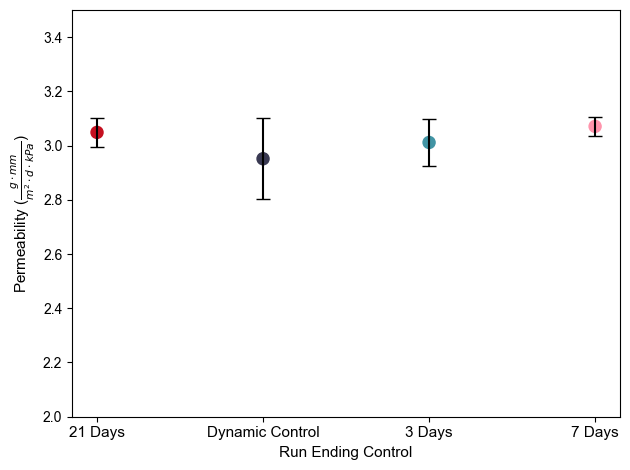

In [742]:
nylon_fit=fits[4:8,0]/10*60*24*(100**2)*0.002*25.4/(0.5*2.81)*(-1)
nylon_fits_dynamic=fits_dynamic[4:8,0]/10*60*24*(100**2)*0.002*25.4/(0.5*2.81)*(-1)
nylon_fits_3days=fits_3day[4:8,0]/10*60*24*(100**2)*0.002*25.4/(0.5*2.81)*(-1)
nylon_fits_7days=fits_7day[4:8,0]/10*60*24*(100**2)*0.002*25.4/(0.5*2.81)*(-1)

fig,ax= plt.subplots(layout='tight')

ax.scatter([1,2,3,4],[np.mean(nylon_fit),np.mean(nylon_fits_dynamic),np.mean(nylon_fits_3days),np.mean(nylon_fits_7days)],color=[pinks[2],purples[2],blues[2],pinks[0]],s=75)
ax.errorbar([1,2,3,4],[np.mean(nylon_fit),np.mean(nylon_fits_dynamic),np.mean(nylon_fits_3days),np.mean(nylon_fits_7days)],yerr=[np.std(nylon_fit),np.std(nylon_fits_dynamic),np.std(nylon_fits_3days),np.std(nylon_fits_7days)],xerr=None,fmt='none',capsize=5,color='black')
ax.set_xlabel('Run Ending Control',size=11)
ax.set_ylabel(r'Permeability ($\frac{g\cdot mm}{m^2\cdot d\cdot kPa}$)',size=11)
ax.set_ylim([2,3.5])
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xticks([1,2,3,4],['21 Days','Dynamic Control','3 Days','7 Days'],size=11)
plt.savefig('./run_dynamic_end'+'.pdf',dpi=300)